<a href="https://colab.research.google.com/github/Y25NHWI/3-2A.I/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from google.colab import files

uploaded = files.upload()   # sample_computer_vision.zip 올리기


Saving sample_computer_vision.zip to sample_computer_vision.zip


In [3]:
!unzip -q sample_computer_vision.zip -d /content/


In [4]:
import os

data_dir = "/content/sample_computer_vision"
for root, dirs, files in os.walk(data_dir):
    print(root)
    break


/content/sample_computer_vision


In [10]:
import torch
from torchvision import datasets, transforms

data_dir = "/content/sample_computer_vision"

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(f"{data_dir}/{x}", data_transforms[x])
    for x in ["train", "val"]
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=6, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
print("classes:", class_names)


classes: ['cats', 'dogs']


In [6]:
import time
import copy
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train" and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)
    return model


In [7]:
from torchvision import models

model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)   # cats/dogs니까 2

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, num_epochs=10)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]


Epoch 0/9
----------
train Loss: 0.5143 Acc: 0.7794
val Loss: 0.1837 Acc: 0.9450

Epoch 1/9
----------
train Loss: 0.4692 Acc: 0.8024
val Loss: 0.3164 Acc: 0.8450

Epoch 2/9
----------
train Loss: 0.5867 Acc: 0.7715
val Loss: 0.2862 Acc: 0.8850

Epoch 3/9
----------
train Loss: 0.4307 Acc: 0.8194
val Loss: 0.1642 Acc: 0.9550

Epoch 4/9
----------
train Loss: 0.5133 Acc: 0.8094
val Loss: 0.1698 Acc: 0.9450

Epoch 5/9
----------
train Loss: 0.3632 Acc: 0.8573
val Loss: 0.1440 Acc: 0.9650

Epoch 6/9
----------
train Loss: 0.4145 Acc: 0.8393
val Loss: 0.1734 Acc: 0.9600

Epoch 7/9
----------
train Loss: 0.3483 Acc: 0.8593
val Loss: 0.1147 Acc: 0.9750

Epoch 8/9
----------
train Loss: 0.3169 Acc: 0.8663
val Loss: 0.1152 Acc: 0.9700

Epoch 9/9
----------
train Loss: 0.2906 Acc: 0.8713
val Loss: 0.1174 Acc: 0.9700

Training complete in 1m 11s
Best val Acc: 0.975000


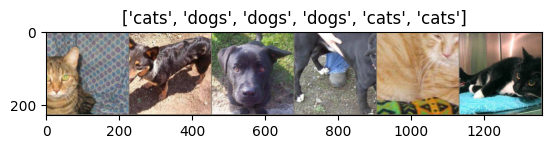

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])